In [24]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline

global globvar
global mask_lines
global xleft_old
global yleft_old
global xright_old
global yright_old
global curve_right_all
global curve_left_all
global frame_counter 
global curve_left_old
global curve_right_old 
global  rigth_fitx_old 
global left_fitx_old 

rigth_fitx_old = [1,2]
left_fitx_old = [1,2]


curve_left_old   = - 1
curve_right_old  = - 1 

curve_left_all = np.zeros((10,3))
curve_right_all = np.zeros((10,3))

yright_old = 0
yleft_old=0
frame_counter = 0
globvar = -1

In [25]:
def undistort_image(img):
    dist =  np.load('./assets/dist.npy')
    mtx =  np.load('./assets/mtx.npy')
    
    out = cv2.undistort(img, mtx, dist, None, mtx)
    
    return out

In [35]:
def birds_eye(img):

     # Get image dimensions
    (h, w) = (img.shape[0], img.shape[1])
    # Define source points
    src = np.float32([[w // 2 - 76, h * .625], [w // 2 + 76, h * .625], [-100, h], [w + 100, h]])
    # Define corresponding destination points
    dst = np.float32([[100, 0], [w - 100, 0], [100, h], [w - 100, h]])

    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    img_size = (img.shape[0],img.shape[1])
    
    out = cv2.warpPerspective(img, M, (w, h))
    
    return out

def undo_birds_eye(img):

     # Get image dimensions
    (h, w) = (img.shape[0], img.shape[1])
    # Define source points
    src = np.float32([[w // 2 - 76, h * .625], [w // 2 + 76, h * .625], [-100, h], [w + 100, h]])
    # Define corresponding destination points
    dst = np.float32([[100, 0], [w - 100, 0], [100, h], [w - 100, h]])

    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    img_size = (img.shape[0],img.shape[1])
    
    out = cv2.warpPerspective(img, Minv, (w, h))
    
    return out

def sobelxy (img,thresh = (0,255)): 
    sobel_kernel=3
    sobel_x = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobel_y = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # Calculate the magnitude
    magnitude = np.sqrt(sobel_x ** 2 + sobel_y ** 2)
    # Scale to 8-bit (0 - 255) and convert to type = np.uint8
    magnitude = (magnitude * 255 / np.max(magnitude)).astype(np.uint8)
    # Create a binary mask where mag thresholds are met
    mask = np.zeros_like(magnitude)
    mask[(magnitude >= thresh[0]) & (magnitude <= thresh[1])] = 1
    # Return this mask as your binary_output image
    return mask
    
    

def sobelx(img,thresh = (0,255)):
  
    #H,L,S = convert_hls(img)
     # Sobel x
    sobel_kernel=3
    sobelx = np.absolute(cv2.Sobel(img, cv2.CV_64F, 1, 0,ksize=sobel_kernel))
    scaled_sobel = np.uint8(255*sobelx/np.max(sobelx))   
    
     # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    
    return sxbinary

def sobely(img,thresh = (0,255)):
    #H,L,S = convert_hls(img)
     # Sobel x
    sobel_kernel=3
    sobelx = np.absolute(cv2.Sobel(img, cv2.CV_64F, 0, 1,ksize=sobel_kernel))
    scaled_sobel = np.uint8(255*sobelx/np.max(sobelx))   
    
     # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    
    return sxbinary

def dir_threshold(img, sobel_kernel=3, thresh=(0.7, 1.3)):
    
   # Apply the following steps to img
    # 1) Convert to grayscale
    #H,L,S = convert_hls(img)
    # 2) Take the gradient in x and y separately
    sobelx = np.absolute(cv2.Sobel(img, cv2.CV_64F, 1, 0,ksize=sobel_kernel))
    sobely = np.absolute(cv2.Sobel(img, cv2.CV_64F, 0, 1,ksize=sobel_kernel))
    
    # 3) Take the absolute value of the x and y gradients
    
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    arc_tanh = np.arctan2(sobely,sobelx)
    # 5) Create a binary mask where direction thresholds are met
    binary_output = np.zeros_like(arc_tanh)
    # 6) Return this mask as your binary_output image
    binary_output[(arc_tanh >= thresh[0]) & (arc_tanh <= thresh[1])] = 1
    return binary_output

def gaussian_blur(img, kernel_size = 5):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def convert_hls(img):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    H = hls[:,:,0]
    L = hls[:,:,1]
    S = hls[:,:,2]
    return H,L,S

def schannel_thresh (img,thresh=(20,100)):
    
    H,L,S = convert_hls(img)
    
    out = np.zeros_like(S)
    out[(S>=thresh[0]) & (S<= thresh[1])] = 1
    
    return out

def color_magnitude(img,thresh=(0,255)):
    out = np.zeros_like(img)
    out[(img>=thresh[0]) & (img<= thresh[1])] = 1
    return out

def process_image(img_o):
    global globvar
    global mask_lines
    global  rigth_fitx_old 
    global left_fitx_old 
     
    #img = gaussian_blur(img_o, kernel_size = 3)  
    
    img = thresholed_image(img_o)
    
    #if globvar !=-1 :
    #    out = np.uint8(np.multiply(img,mask_lines))
    #    out = np.stack((mask_lines,out,np.zeros_like(out)),axis = 2)
    #else:
    out = mask_squares(img) 
    
    left_fitx,rigth_fitx,left_ploty,right_ploty,(curve_left,curve_rigth) = extract_lines_new(out)
   
    '''
    mask_lines_l = mask_for_lines(left_ploty,left_fitx)
    mask_lines_r = mask_for_lines(right_ploty,rigth_fitx)
    mask_lines = np.logical_or(mask_lines_r,mask_lines_l)
    '''
    
    curvature = (curve_left+curve_rigth)/2
        
    mask_lines = mask_between_lines(left_fitx,rigth_fitx,left_ploty)
   
    globvar = 1
    #old_frame_left = [left_lploty,left_fitx]
    #old_frame_right = [right_ploty,rigth_fitx]
    
    #mask_lines = np.zeros_like(img)
    #mask_lines[np.int32(left_ploty),np.int32(left_fitx)] = 1
    #mask_lines[np.int32(right_ploty),np.int32(rigth_fitx)]= 1
    
    out = np.zeros_like(img_o)
    out[:,:,1] = np.uint8(255*mask_lines/np.max(mask_lines))
    out  = undo_birds_eye(out)
    final_out =  cv2.addWeighted(img_o, 1, np.uint8(out), 0.3, 0)
    


    
    distance = distance_between_lines(left_fitx,rigth_fitx)
    
    final_out =cv2.putText(final_out,  'Distance (left) :       {:.1f} m'.format(distance), (800, 50), \
                           cv2.FONT_HERSHEY_SIMPLEX, .8, (255, 255, 255), 2)
    final_out =cv2.putText(final_out,  'Curvature:       {:.2f} m'.format(curvature), (800, 90), \
                           cv2.FONT_HERSHEY_SIMPLEX, .8, (255, 255, 255), 2)

 
    rigth_fitx_old =rigth_fitx
    left_fitx_old = left_fitx
   # final_out =  cv2.addWeighted(img_o, 1, out, 0.3, 0,dtype = np.uint8)
    #out = np.stack((np.zeros_like(out[:,:,2]),np.zeros_like(out[:,:,2]),out[:,:,2]),axis = 2)
    #img_o[:,:,2] = out[:,:,2]
    
    return final_out


def process_image_mod(img_o):
    global globvar
    global mask_lines
    #img = gaussian_blur(img_o, kernel_size = 3)  
    
    img = thresholed_image(img_o)
    
    #if globvar !=-1 :
    #    out = np.uint8(np.multiply(img,mask_lines))
    #    out = np.stack((mask_lines,out,np.zeros_like(out)),axis = 2)
    #else:
    out_sq = mask_squares(img) 
    
    left_fitx,rigth_fitx,left_ploty,right_ploty,(curve_left,curve_rigth) = extract_lines_new(out_sq)
   
    '''
    mask_lines_l = mask_for_lines(left_ploty,left_fitx)
    mask_lines_r = mask_for_lines(right_ploty,rigth_fitx)
    mask_lines = np.logical_or(mask_lines_r,mask_lines_l)
    '''
    
    curvature = (curve_left+curve_rigth)/2
        
    mask_lines = mask_between_lines(left_fitx,rigth_fitx,left_ploty)
   
    globvar = 1
    #old_frame_left = [left_lploty,left_fitx]
    #old_frame_right = [right_ploty,rigth_fitx]
    
    #mask_lines = np.zeros_like(img)
    #mask_lines[np.int32(left_ploty),np.int32(left_fitx)] = 1
    #mask_lines[np.int32(right_ploty),np.int32(rigth_fitx)]= 1
    
    out = np.zeros_like(img_o)
    out[:,:,1] = np.uint8(255*mask_lines/np.max(mask_lines))
    out  = undo_birds_eye(out)
    final_out =  cv2.addWeighted(img_o, 1, np.uint8(out), 0.3, 0)
      
    
   # final_out =  cv2.addWeighted(img_o, 1, out, 0.3, 0,dtype = np.uint8)
    #out = np.stack((np.zeros_like(out[:,:,2]),np.zeros_like(out[:,:,2]),out[:,:,2]),axis = 2)
    #img_o[:,:,2] = out[:,:,2]
    
    return out_sq


def thresholed_image(img_o):
    _,_,img = convert_hls(img_o)
    
    thresh_sobels  = (20, 100) 
    threshold_color = (170,255)
    thresh_angle=(.7, 1.3)
    
    undst = undistort_image(img)
    #undst = birds_eye(undst)
    
    #outh = schannel_thresh (undst,thresh_h)
    #outh = np.uint8(255*outh/np.max(outh))
    
    outx = sobelx(undst,thresh_sobels)
    outy = sobely(undst,thresh_sobels)
    outxy = sobelxy(undst,thresh_sobels)
    outdir = dir_threshold(undst, sobel_kernel=3, thresh=thresh_angle )
    
    gradient_mask = np.zeros_like(outx)
    gradient_mask[((outx == 1) & (outy == 1)) | ((outxy == 1) & (outdir == 1))] = 1
    
    #outx = np.uint8(255*outx/np.max(outx))
    
    color_mask = color_magnitude(undst, threshold_color)
    #color_mask = np.zeros_like()
    mask = np.zeros_like(color_mask)
    mask[(gradient_mask == 1) | (color_mask == 1)] = 1
    
    
  
    out = np.uint8(255*mask/np.max(mask))
    out = birds_eye(out)
    
    
    
    return out

def mask_for_lines(y_fit,x_fit):
    
    y_aux = np.int32(y_fit)
    x_aux = np.int32(x_fit)
  
    mask = np.zeros((720,1280),dtype=np.uint8)
    for idx in range (-75,75):
        if np.all(x_aux+idx < 1280):
            mask[y_aux ,x_aux+idx] = 1
        
    return mask
    
def mask_between_lines(x_fit_l,x_fit_r,y_fit_r):
    
    
    y_aux =  np.int32(y_fit_r)
    xl_aux = np.int32(x_fit_l)
    xr_aux = np.int32(x_fit_r)
    
    max_idx = np.min([y_aux.size, xl_aux.size  ,xr_aux.size ])
  

    
    mask = np.zeros((720,1280),dtype=np.uint8)
    for idx in range(0,max_idx):
        mask[y_aux[idx] , xl_aux[idx] : xr_aux[idx]] = 1

        
    return mask

def distance_between_lines(x_fit_l,x_fit_r):
    
    xm_per_pix = 3.7 / 700  # meters per pixel in x dimension
    
    w = 1280
    distance = np.zeros(2)
    
    index = np.min([x_fit_l.size,x_fit_r.size])-1
    
    
    distance[0] = np.absolute((w // 2 - x_fit_l[index]) * xm_per_pix)
    distance[1] = np.absolute((w // 2 - x_fit_r[index]) * xm_per_pix)
    
    out = (np.absolute(distance[0]-distance[1])/2)
    
    return out

In [27]:
def windowing(img,slicing = 9):
    hwindow = int(img.shape[0]/slicing)
    histogram_w =np.zeros((img.shape[1],slicing))
    for idx in range(0,slicing):
        histogram_w[:,idx] = (np.sum(img[idx*hwindow :((idx+1)*hwindow)-1 ,], axis=0))
                                          
    return histogram_w

def windowing_h(img,slicing = 9):
    hwindow = int(img.shape[0]/slicing)
    histogram_h =np.zeros((hwindow,slicing))
    for idx in range(0,slicing):
        histogram_h[:,idx] = (np.sum(img[idx*hwindow :((idx+1)*hwindow) ,], axis=1))
                                          
    return histogram_h

def lr_lines_rows(histogram_h):
    rmax = np.zeros(histogram_h.shape[1])
    
    for idx in range(0,histogram_h.shape[1]):
         rmax[idx] = np.argmax(histogram_h[:,idx])+idx*histogram_h.shape[0]
    
    return rmax

def lr_lines_horizontal(histogram_w):
    (img_length,nwindows) = np.shape(histogram_w)
    lmax = np.zeros(nwindows)
    rmax = np.zeros(nwindows)
    
    for idx in range(0,nwindows):
       
        if np.max(histogram_w[0:int(img_length/2)-1,idx]) < 100:
            lmax[idx] = -1
        else:
            lmax[idx] = np.argmax(histogram_w[0:int(img_length/2)-1,idx])
        
        
        if np.max(histogram_w[int(img_length/2):,idx]) < 100:
            rmax[idx] = -1
        else:
            rmax[idx] = np.argmax(histogram_w[int(img_length/2):,idx])+int(img_length/2)       
        
    return lmax,rmax

def remove_false_positives (colmax,rowmax):
    idx = np.where(colmax < 0)
    colmax = np.delete(colmax,idx)
    rowmax = np.delete(rowmax,idx)
    
    return colmax,rowmax

def sanity_check (colmax,rowmax,thresh):
    idx = np.where(colmax <= thresh[0])
    
    colmax = np.delete(colmax,idx)
    rowmax = np.delete(rowmax,idx)
    
    idx = np.where(colmax >= thresh[1])
    
    colmax = np.delete(colmax,idx)
    rowmax = np.delete(rowmax,idx)
    
    
    return colmax,rowmax

def polyfit(x,y,grade = 2):
    curve = np.polyfit(y,x,2)
    
    return curve

def curverad(x,y):
    
    ym_per_pix = 27 / 720  # meters per pixel in y dimension
    xm_per_pix = 3.7 / 700  # meters per pixel in x dimension
    
    poly_coef = np.polyfit(y * ym_per_pix, x * xm_per_pix, 2)
    curvature_radius = ((1 + (2 * poly_coef[0] * 720 * ym_per_pix + poly_coef[1]) ** 2) ** 1.5) / np.absolute(2 * poly_coef[0])
    
    #y_eval = np.max(y_eval)
    #curvature_radius = ((1 + (2*curve[0]*y_eval + curve[1])**2)**1.5) / np.absolute(2*curve[0])
    return curvature_radius

In [28]:

def smooth_curve(curve_in,counter,elems = 20):
    

    elems = elems -1
    if counter == 0:   
        out = curve_in[elems,:]
    elif counter > 0 and counter < elems:
        out = np.average(curve_in[elems-counter:elems,:],axis = 0)
    elif counter >= elems:
        out = np.average(curve_in,axis=0)
    
    return out

In [29]:
def square(center, windowing = 9, half_width = 100):
    h = int(720/windowing)
    
    v = np.zeros((4,2),dtype = np.int32)
    
    v[0,] = [center[0] + int(h/2),center[1]-half_width]
    v[1,] = [center[0]  + int(h/2),center[1] +half_width]
    v[2,] = [center[0]  - int(h/2),center[1] + half_width]
    v[3,] = [center[0]  - int(h/2),center[1] -half_width]
    
    for i in range(0,4):
        if v[i,0]<0:
            v[i,0] = 0
        if v[i,1] > 1279:
            v[i,1] = 1279
        
    return v

def square_mask(v):
    mask = np.zeros((720,1280),dtype = np.uint8)
    
    mask[v[0,0],v[0,1]:v[1,1]] = 1
    mask[v[2,0]:v[0,0],v[0,1]] = 1 
    mask[v[2,0]:v[0,0],v[1,1]] = 1 
    mask[v[2,0],v[0,1]:v[1,1]] = 1
    
    return mask


def square_mask_filled(v):
    mask = np.zeros((720,1280),dtype = np.uint8)
    
    mask[v[2,0]:v[0,0],v[0,1]:v[1,1]] = 1
    
    return mask

def histogram(img,plotear = 0):
    #hwindow = int(img.shape[0]/slicing)
    histogram_out =np.zeros((img.shape[1]))
    histogram_out = (np.sum(img, axis=0))
    
    if plotear == 1:     
        plt.plot(histogram_out)
        
                                          
    return histogram_out

def hist_max(histogram_in):  
    if np.max(histogram_in) < 5:
        max_position = np.int32(histogram_in.shape[0]/2)
    else:
        max_position = np.argmax(histogram_in)
    return max_position
    
def new_square(old_center,height = 80):    
    new_center =[old_center[0]-80,old_center[1]]    
    return new_center
    
def swing(xfit):

    out = (np.max(xfit)-np.min(xfit))
    return out

def swing_ratio(xfit,xfit_old):
    swing_old = swing(xfit_old)
    swing_new = swing(xfit)
    return swing_new/swing_old

In [30]:
def extract_lines_new(img):
    
    global curve_right_all
    global curve_left_all
    global frame_counter 
    global xleft_old
    global yleft_old
    global xright_old
    global yright_old
    global curve_left_old
    global curve_right_old 

    yleft,xleft   = non_zero_points(img,1)
    yright,xright = non_zero_points(img,0)
    
    left_fitx,rigth_fitx,left_ploty,right_ploty,(curvature_left,curvature_right)  = \
    points_and_curvature(xleft,yleft,xright,yright)
  
    
    #if curve_left_old == -1:
    #    curve_left_old = curvature_left
    #   curve_right_old = curvature_right
        
    #Calculate polyfit
    
    if (xleft.size ) < 1000 :
        xleft = xleft_old
        yleft = yleft_old
        recalculate = 1
    else:
        xleft_old = xleft
        yleft_old = yleft
        recalculate = 0
        
    if xright.size < 5000 : 
        xright = xright_old
        yright = yright_old
        recalculate = 1
    else:
        xright_old = xright
        yright_old = yright
        
        
    
    if recalculate == 1:
        frame_counter = frame_counter - 1
        recalculate   = 0
        left_fitx,rigth_fitx,left_ploty,right_ploty,(curvature_left,curvature_right)  =\
        points_and_curvature(xleft,yleft,xright,yright)
        
    
        
    
    
    return left_fitx,rigth_fitx,left_ploty,right_ploty,(curvature_left,curvature_right)

def points_and_curvature(xleft,yleft,xright,yright):

    global curve_right_all
    global curve_left_all
    global frame_counter 
    global xleft_old
    global yleft_old
    global xright_old
    global yright_old
    
    
    curve_left = polyfit(xleft,yleft)
    curve_rigth = polyfit(xright,yright)   
    
    
    
    max_elem = 9
        
    
    for indice in range(0,max_elem):
        curve_left_all[0+indice,:] = curve_left_all[1+indice,:]
        curve_right_all[0+indice,:] = curve_right_all[1+indice,:]     
   
    curve_left_all[max_elem,:] = curve_left
    curve_right_all[max_elem,:] = curve_rigth
    
    #print(curve_left_all)
    #print(curve_right_all)
        
    curve_left  = smooth_curve(curve_left_all, frame_counter,elems=10 )
    curve_rigth = smooth_curve(curve_right_all,frame_counter,elems=10)
   
    
    frame_counter = frame_counter + 1
    
    
    #Obtain a continuous line
    ploty = np.linspace(0, 720-1, 720 )
    left_fitx = curve_left[0]*ploty**2 + curve_left[1]*ploty + curve_left[2]
    rigth_fitx = curve_rigth[0]*ploty**2 + curve_rigth[1]*ploty + curve_rigth[2]
    left_ploty =ploty
    right_ploty=ploty
    #left_fitx,left_ploty = sanity_check (left_fitx,ploty,[0 ,img.shape[1]])
    #rigth_fitx,right_ploty = sanity_check (rigth_fitx,ploty,[0 ,img.shape[1]])
    
    #Calculate curvature radius
    curvature_left  = curverad(left_fitx,ploty)
    curvature_right = curverad(rigth_fitx,ploty)
    #curvature = smooth_curvature(curvature_left,curvature_right)
    
    return left_fitx,rigth_fitx,left_ploty,right_ploty,(curvature_left,curvature_right)

def non_zero_points(img,left_or_right = 1):
    
    w = img.shape[1]
    
    if left_or_right == 1:
        vecty,vectx = np.where(img[:,0:int(w/2),2]>0)
    else:
        vecty,vectx = np.where(img[:,int(w/2):,2]>0)
        vectx = vectx + int(w/2)
    return vecty,vectx

def mask_squares(img):

    out = np.zeros((720,1280,3))
    initial_center = [719-40,350]
    out_mask = np.zeros((720,1280))
    mask_test= np.zeros((720,1280))

    for i in range(0,9): 
        if i == 0:
            center = initial_center
        else:
        
            center = new_square(center)
        
        v = square(center)
    
        hist = histogram(img[v[3,0]:v[0,0], v[0,1]:v[1,1]])
        max_position = hist_max(hist)
    
        center[1] = v[0,1]+max_position
       
    
        mask = square_mask(v)
        mask_test = np.logical_or(mask_test,square_mask_filled(v))
    
        out_mask = np.logical_or (mask,out_mask)
    
    initial_center = [719-40,1020]

    for i in range(0,9): 
        if i == 0:
            center = initial_center
        else:
        
            center = new_square(center)
        
        v = square(center)
    
        hist = histogram(img[v[3,0]:v[0,0], v[0,1]:v[1,1]])
        max_position = hist_max(hist)        
        center[1] = v[0,1]+max_position
     
   
        mask = square_mask(v)
        mask_test = np.logical_or(mask_test,square_mask_filled(v))
    
        out_mask = np.logical_or (mask,out_mask)
        
    masked_image = np.multiply(mask_test,img) 
    
    
    out[:,:,0] = np.uint8(out_mask*255)
    out[:,:,1] = masked_image
    out[:,:,2] = np.uint8(mask_test*255)
    
       
    return out

(1280, 720)


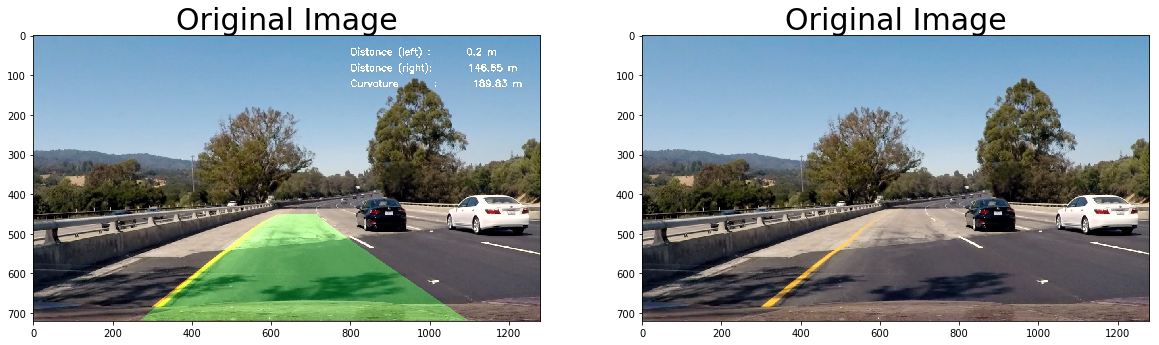

In [31]:
img_o = cv2.imread('test_images/test4.jpg')
img_o = cv2.cvtColor(img_o, cv2.COLOR_BGR2RGB)
#img = undistort_image(img_o)
curve_left_all = np.zeros((10,3))
curve_right_all = np.zeros((10,3))   
frame_counter = 0
globvar = -1
curve_left_old   = - 1
curve_right_old  = - 1 
rigth_fitx_old = [1,2]
left_fitx_old = [1,2]


img = process_image(img_o)


#img = birds_eye(img)
img_size = (img.shape[1], img.shape[0])

print(img_size)
f, (ax1,ax2)= plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(img_o)
ax2.set_title('Original Image', fontsize=30)

In [32]:
final_out =  cv2.addWeighted(img_o, 1, np.uint8(img), 0.3, 0)

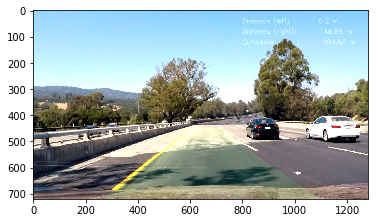

In [33]:
plt.imshow(final_out)

In [36]:
curve_left_all = np.zeros((10,3))
curve_right_all = np.zeros((10,3))   
frame_counter = 0
globvar = -1
curve_left_old   = - 1
curve_right_old  = - 1 


rigth_fitx_old = [1,2]
left_fitx_old = [1,2]

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

globvar = -1

output = 'project_video_anotated_final.mp4'
clip1 = VideoFileClip("project_video.mp4")

white_clip = clip1.fl_image(process_image ) #NOTE: this function expects color images!!
print(type(white_clip))
%time white_clip.write_videofile(output, audio=False)


<class 'moviepy.video.io.VideoFileClip.VideoFileClip'>
[MoviePy] >>>> Building video project_video_anotated_final.mp4
[MoviePy] Writing video project_video_anotated_final.mp4



100%|█████████████████████████████████████▉| 1260/1261 [08:05<00:00,  2.63it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_anotated_final.mp4 

Wall time: 8min 6s


In [ ]:
curve_left_all = np.zeros((10,3))
curve_right_all = np.zeros((10,3))   
frame_counter = 0
globvar = -1

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

globvar = -1

output = 'project_video_anotated_mod.mp4'
clip1 = VideoFileClip("project_video.mp4")

white_clip = clip1.fl_image(process_image_mod ) #NOTE: this function expects color images!!
print(type(white_clip))
%time white_clip.write_videofile(output, audio=False)


In [ ]:
a = np.array([2,3,4])
print(a.size) 

In [ ]:
pr =[0,0]
rpwe =[1,3]

a = np.concatenate((pr,rpwe), axis=0)

In [ ]:
print(a)

In [ ]:
curve_right_all

In [ ]:
curve_left_all

In [ ]:
curve = smooth_curve(curve_left_all,frame_counter)

In [ ]:
a=range(0,5)

In [ ]:
for indn in range(0,5):
    print(indn)
